# Piecewise Warping

This notebook shows how to fit a piecewise linear warping model and perform a hyperparameter search to tune the regularization strengths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Generate a dataset from a piecewise warped model.

In [2]:
from affinewarp.datasets import piecewise_warped_data
binned, true_model = piecewise_warped_data(
    n_knots=1,
    n_trials=100,
    n_timepoints=150,
    n_neurons=100,
    clip_y_knots=False,
    template_scale=1.0,
    template_drop=.9,
    template_smoothness=2,
    noise_type="poisson",
    seed=1234)

#### Fit a model to make sure we approximate the ground truth.

In [3]:
# Fit warping model.
from affinewarp import ShiftWarping, PiecewiseWarping

models = [
    ShiftWarping(smoothness_reg_scale=20.0),
    PiecewiseWarping(n_knots=0, warp_reg_scale=1e-6, smoothness_reg_scale=20.0),
    PiecewiseWarping(n_knots=1, warp_reg_scale=1e-6, smoothness_reg_scale=20.0),
    PiecewiseWarping(n_knots=2, warp_reg_scale=1e-6, smoothness_reg_scale=20.0),
]

for m in models:
    m.fit(binned, iterations=50, warp_iterations=200)

Loss improvement: 14.03%: 100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Text(0, 0.5, 'loss')

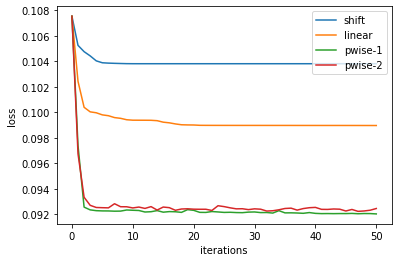

In [4]:
# Learning curve.
for m, label in zip(models, ('shift', 'linear', 'pwise-1', 'pwise-2')):
    plt.plot(m.loss_hist, label=label)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')

#### Plot example neuron before and after alignment

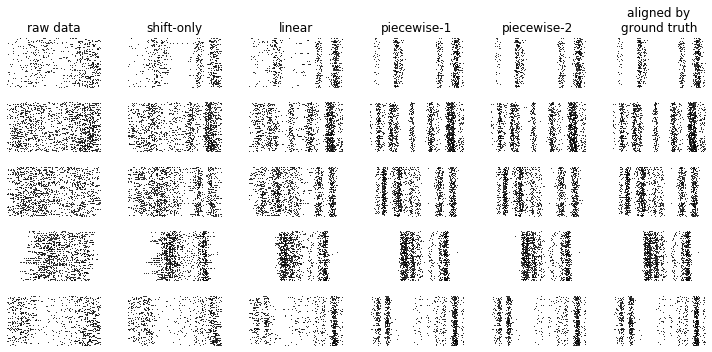

In [5]:
from affinewarp import SpikeData
fig, axes = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(10, 5))


for n, axr in enumerate(axes):
    raw_spikes = SpikeData(*np.where(binned), 0, binned.shape[1]).select_neurons(n)
    true_align = true_model.transform(raw_spikes)
    est_align = [m.transform(raw_spikes) for m in models]

    axr[0].scatter(raw_spikes.spiketimes, raw_spikes.trials, lw=0, color='k', s=1)
    axr[-1].scatter(true_align.spiketimes, true_align.trials, lw=0, color='k', s=1)
    
    axr[1].scatter(est_align[0].spiketimes, est_align[0].trials, lw=0, color='k', s=1)
    axr[2].scatter(est_align[1].spiketimes, est_align[1].trials, lw=0, color='k', s=1)
    axr[3].scatter(est_align[2].spiketimes, est_align[2].trials, lw=0, color='k', s=1)
    axr[4].scatter(est_align[3].spiketimes, est_align[3].trials, lw=0, color='k', s=1)


axes[0, 0].set_title("raw data")
axes[0, -1].set_title("aligned by\nground truth")

axes[0, 1].set_title("shift-only")
axes[0, 2].set_title("linear")
axes[0, 3].set_title("piecewise-1")
axes[0, 4].set_title("piecewise-2")

for ax in axes.ravel():
    ax.axis('off')
    ax.set_ylim([0, 100])
    ax.set_xlim([0, binned.shape[1]])

plt.tight_layout()
plt.subplots_adjust(wspace=.3, hspace=.3)

#### Compare estimated model to ground truth.

Text(0.5, 1.0, 'Estimated warping functions')

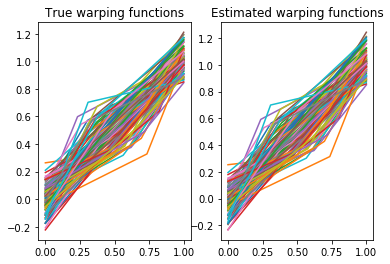

In [6]:
# Compare true warping functions to estimated model.
fig, axes = plt.subplots(1, 2)

axes[0].plot(true_model.x_knots.T, true_model.y_knots.T);
axes[0].set_title("True warping functions")

axes[1].plot(models[2].x_knots.T, models[2].y_knots.T);
axes[1].set_title("Estimated warping functions")

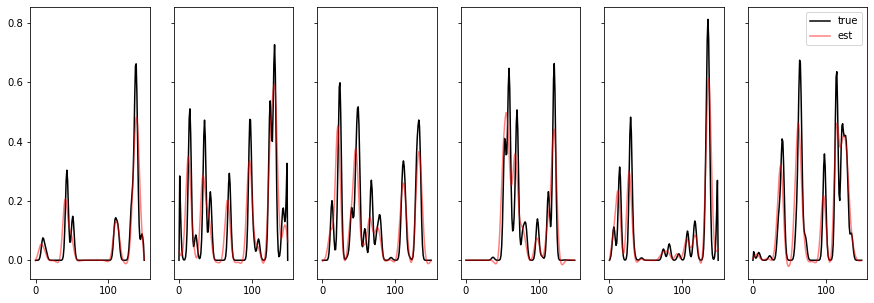

In [7]:
# Compare true template to estimated template across some neurons
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.template[:, i], color='k', label='true')
    ax.plot(models[2].template[:, i], color='r', alpha=.5, label='est')

axes[-1].legend()    

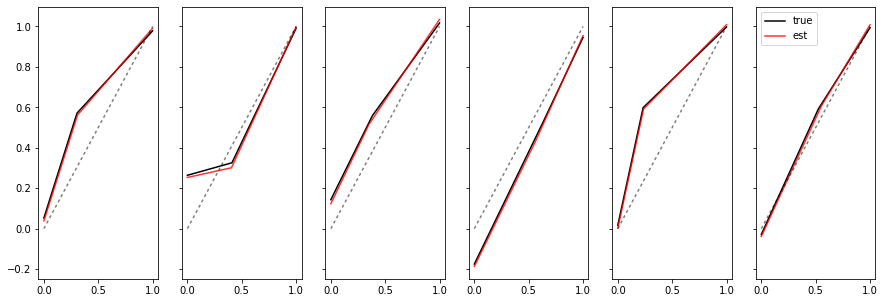

In [8]:
# Compare true warping functions to estimated warping functions.
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.x_knots[i], true_model.y_knots[i], color='k', label='true')
    ax.plot(models[2].x_knots[i], models[2].y_knots[i], color='r', alpha=.8, label='est')
    ax.plot([0, 1], [0, 1], color='k', dashes=[2, 2], alpha=.5)

axes[-1].legend()    

## Perform a hyperparameter search

Above, we hand-tuned the model regularization to get a good fit. Here we take a more unbiased approach by randomly sampling different hyperparameters and comparing their performance on a held out set of units.

In [9]:
from affinewarp.crossval import paramsearch

# Search over warping complexity.
#    -1 => shift-only model
#    0  => linear model
#    1  => piecewise linear model with 1 knot
#    2  => piecewise linear model with 2 knots
#    3  => piecewise linear model with 3 knots
knot_range = (-1, 3)

# Number of randomized cross-validation runs to perform.
num_models = 3

# Number of parameters to randomly sample.
n_valid_samples = 10

#  IMPORTANT NOTE
#  --------------
#  This number of validation samples should generally be larger, but is
#  kept small here so that the example runs in a reasonable amount of
#  time. More validation samples will result in better tuning of the
#  template smoothness and warp regularization parameters.

# Run the parameter search.
results = paramsearch(
    binned,  # time series data (trials x timebins x features/units)
    num_models,  # number of parameters to randomly sample
    n_valid_samples,  # number of hyperparameter samples per validation set
    n_train_folds=3,  # ratio of data to use for training
    n_valid_folds=1,  # ratio of data to use for validation
    n_test_folds=1,  # ratio of data to use for testing
    knot_range=knot_range,  # range of knots in warping function
    warpreg_range=(1e-3, 1e-2),  # range of warp regularization scale
    smoothness_range=(1e-1, 1e0),  # range of smoothness regularization scale
    iter_range=(50, 51),  # range of optimization iterations
    warp_iter_range=(50, 51), # range of warp iterations
)

100%|██████████| 120/120 [07:45<00:00,  3.54s/it]

#### Visualize the results of the hyperparameter search

Here, we show the performance for each model class (shift-only warping, linear warping, and piecewise warping with 1 knot) on a the training and test set. We choose the top five models in each category based on test performance. These top five models have well tuned smoothness and warp regularization strengths.

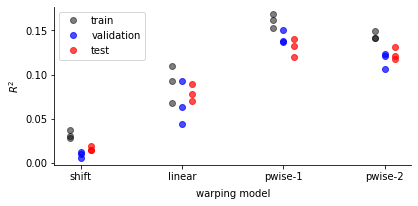

In [10]:
train_rsq = results["train_rsq"]
valid_rsq = results["valid_rsq"]
test_rsq = results["test_rsq"]
knots = results["knots"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

plt.plot(knots-.1, np.median(train_rsq, axis=1), 'ok', label='train', alpha=.5)
plt.plot(knots, np.median(valid_rsq, axis=1), 'ob', label='validation', alpha=.7)
plt.plot(knots+.1, test_rsq, 'or', label='test', alpha=.7)

ax.set_xticks(range(*knot_range))
ax.set_xticklabels(['shift', 'linear', 'pwise-1', 'pwise-2', 'pwise-3'])

ax.set_ylabel("$R^2$")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('warping model', labelpad=7)
ax.legend()

fig.tight_layout()